In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import file_utils    
import utils
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def get_missed_predictions(tourney_comp_ratings, model_features, numeric_feature_to_scale, prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   
    missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)
    supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

    supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)
    
    missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

    missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

    missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

    missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
        len(model_features)

    missed_predictions['game_index'] = missed_predictions.index
    
    return missed_predictions

In [3]:
def eliminate_features_logistic_regression(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    important_features = utils.display_important_features(classifier.coef_[0], X,0)
    #important_features = display_important_features_regression(classifier, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats

In [4]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [5]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [8]:
numeric_feature_to_scale = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

scaler =StandardScaler()
tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
tourney_comp_ratings.head()

C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,64,2003-03-21 00:00:00.0000000,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,60,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,58,-1,2002,Lose,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,Pacific 12,Pacific 12,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,0.346694,0.240524,0.410802,0.429263,1.259163,8.0,8.0,0.033305,-0.428353,0.367769,0.564274,-0.166349,0.296388,0.141456,-0.145034,0.158184,0.100632,-0.002273,0.166047,0.047449,-0.087067,0.572446,-0.556750
1,2003,64,2003-03-21 00:00:00.0000000,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,85,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,55,1,2002,Win,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,Southeastern,Southland,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,0.673971,0.556288,-0.376883,-0.354283,-0.024608,6.0,7.0,-0.366740,-0.048685,1.092534,-1.365443,-1.774689,1.841726,2.142615,-1.915064,-1.447144,-1.716111,-1.834885,-1.220930,-1.874068,-1.352485,-1.355216,-2.239608
2,2003,32,2003-03-23 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,68,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,62,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,0.837609,-0.359427,0.804645,1.212810,1.831922,9.0,8.0,0.433351,1.177935,0.713928,1.666970,-1.104547,0.407285,-0.184078,-0.519187,-0.621102,-0.613088,-0.477395,-0.617187,-0.501556,-0.633853,-0.531578,-0.351523
3,2003,64,2003-03-21 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,65,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,63,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,Southeastern,Atlantic 10,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-0.962413,0.714170,0.410802,-0.354283,-0.498615,8.0,5.0,1.233442,-0.859130,-0.699959,0.012926,0.369764,-0.152607,0.689340,0.301071,0.454312,0.181736,0.133476,0.247634,0.365294,0.303494,0.134341,0.058930
4,2003,4,2003-04-05 00:00:00.0000000,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,95,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,84,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.019417,-0.896225,1.198488,-0.746056,0.548152,7.0,6.0,0.433351,-0.4867

In [9]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,win_pts,lose_pts,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,60,58,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,0.346694,0.240524,0.410802,0.429263,1.259163,8.0,8.0,0.033305,-0.428353,0.367769,0.564274,-0.166349,0.296388,0.141456,-0.145034,0.158184,0.100632,-0.002273,0.166047,0.047449,-0.087067,0.572446,-0.556750
1,2003,85,55,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,0.673971,0.556288,-0.376883,-0.354283,-0.024608,6.0,7.0,-0.366740,-0.048685,1.092534,-1.365443,-1.774689,1.841726,2.142615,-1.915064,-1.447144,-1.716111,-1.834885,-1.220930,-1.874068,-1.352485,-1.355216,-2.239608
2,2003,68,62,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,0.837609,-0.359427,0.804645,1.212810,1.831922,9.0,8.0,0.433351,1.177935,0.713928,1.666970,-1.104547,0.407285,-0.184078,-0.519187,-0.621102,-0.613088,-0.477395,-0.617187,-0.501556,-0.633853,-0.531578,-0.351523
3,2003,65,63,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-0.962413,0.714170,0.410802,-0.354283,-0.498615,8.0,5.0,1.233442,-0.859130,-0.699959,0.012926,0.369764,-0.152607,0.689340,0.301071,0.454312,0.181736,0.133476,0.247634,0.365294,0.303494,0.134341,0.058930
4,2003,95,84,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.019417,-0.896225,1.198488,-0.746056,0.548152,7.0,6.0,0.433351,-0.486763,-0.101901,0.288600,-0.300377,0.011484,0.052806,-0.130644,-0.137945,0.003306,-0.110873,-0.111348,-0.140369,0.006668,-0.110998,-0.146297


In [10]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)


# for now drop the delta seed features
feature_data.drop(columns=['upset_seed_threshold'], inplace=True)
feature_data.head(10)

,season_t,win_pts,lose_pts,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,60,58,0,0,0.346694,0.240524,0.410802,0.429263,1.259163,0.033305,-0.428353,0.367769,0.564274,-0.166349,0.296388,0.141456,-0.145034,0.158184,0.100632,-0.002273,0.166047,0.047449,-0.087067,0.572446,-0.556750
1,2003,85,55,1,0,0.673971,0.556288,-0.376883,-0.354283,-0.024608,-0.366740,-0.048685,1.092534,-1.365443,-1.774689,1.841726,2.142615,-1.915064,-1.447144,-1.716111,-1.834885,-1.220930,-1.874068,-1.352485,-1.355216,-2.239608
2,2003,68,62,0,0,0.837609,-0.359427,0.804645,1.212810,1.831922,0.433351,1.177935,0.713928,1.666970,-1.104547,0.407285,-0.184078,-0.519187,-0.621102,-0.613088,-0.477395,-0.617187,-0.501556,-0.633853,-0.531578,-0.351523
3,2003,65,63,1,0,-0.962413,0.714170,0.410802,-0.354283,-0.498615,1.233442,-0.859130,-0.699959,0.012926,0.369764,-0.152607,0.689340,0.301071,0.454312,0.181736,0.133476,0.247634,0.365294,0.303494,0.134341,0.058930
4,2003,95,84,0,0,0.019417,-0.896225,1.198488,-0.746056,0.548152,0.433351,-0.486763,-0.101901,0.288600,-0.300377,0.011484,0.052806,-0.130644,-0.137945,0.003306,-0.110873,-0.111348,-0.140369,0.006668,-0.110998,-0.146297
5,2003,79,78,0,0,0.837609,0.335253,0.410802,1.604583,0.686404,-0.766786,1.550301,0.830533,0.839948,-0.970519,0.593014,0.115297,-0.476015,-0.543173,-0.596868,-0.409520,-0.600870,-0.458214,-0.618230,-0.496530,-0.337842
6,2003,81,78,0,0,1.001247,0.619440,0.410802,0.037490,-0.735619,-0.366740,-0.479462,0.093141,0.012926,-0.166349,0.560556,0.235919,-0.145034,-0.184702,0.084411,-0.124447,-0.062396,-0.183711,0.069157,-0.075949,-0.283115
7,2003,76,65,1,0,0.510332,0.903628,0.804645,1.604583,-1.841637,0.433351,0.674145,0.160160,0.012926,-1.506632,1.215116,1.616530,-0.850168,-0.558759,-0.953728,-0.911792,-0.731409,-0.718269,-0.836944,-0.829490,-0.939840
8,2003,68,56,0,0,-0.471498,-0.833072,-0.376883,-1.137829,-0.854121,0.033305,-1.216894,-1.021145,-0.262748,0.369764,-0.375302,-0.064909,0.157166,0.111427,0.279062,0.160626,0.247634,0.177476,0.319116,0.204438,0.086293
9,2003,63,47,0,0,0.019417,0.935204,0.410802,1.212810,0.034643,0.033305,0.477009,0.145568,1.391296,0.235736,0.035827,0.087685,0.027652,0.064669,-0.045356,0.011302,0.068143,0.061896,-0.040200,0.081768,0.182066


In [11]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['win_pts',
 'lose_pts',
 'top_conf_t',
 'top_conf_o',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 25)
(782,)
(196, 25)
(196,)


,win_pts,lose_pts,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
784,92,75,0,1,-0.471498,-0.454156,0.016960,-0.354283,1.239413,0.833397,-0.384545,-0.499559,-0.262748,0.369764,-0.891917,-0.949954,1.365967,1.623240,1.560514,1.246618,1.406167,1.131011,1.584534,1.396083,1.372380
125,70,65,0,1,1.328524,0.366830,-0.770726,0.037490,-0.755369,-0.366740,1.929969,1.368372,-0.262748,-0.970519,0.501051,-0.454387,-0.375282,-0.543173,-0.434658,-0.368796,-0.486648,-0.371529,-0.493251,-0.496530,-0.283115
236,62,54,0,0,0.510332,0.714170,-1.558411,-1.137829,1.417166,-1.166832,1.031909,1.999679,1.115622,-0.434406,0.402777,0.016474,-0.188206,-0.200287,-0.272449,-0.205897,-0.258205,-0.198159,-0.305781,-0.233667,-0.214706
719,78,65,0,0,0.019417,-0.296274,0.016960,-0.746056,-0.301112,0.433351,0.330983,-0.392916,-1.089769,-0.032321,-0.090397,0.076058,0.085214,-0.013259,0.019527,-0.002273,-0.095031,-0.255949,0.162892,-0.268716,-0.118933
808,57,56,1,0,0.019417,-1.433023,1.986174,0.821036,-0.992373,1.633488,-0.041383,-1.212148,0.288600,-1.506632,1.137579,1.667395,-0.950902,-1.057501,-0.969949,-1.359763,-1.318834,-0.833849,-1.243128,-0.776917,-1.021930


array([[54, 35],
       [31, 76]], dtype=int64)

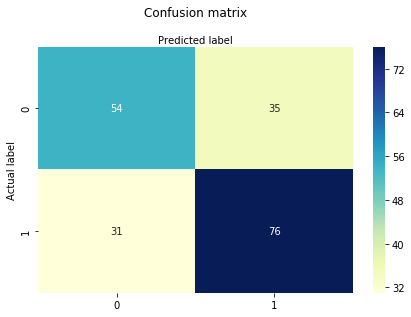

In [13]:
gnb = GaussianNB()

y_pred = gnb.fit(X_train,y_train).predict(X_test)

utils.display_confusion_matrix(y_test, y_pred)

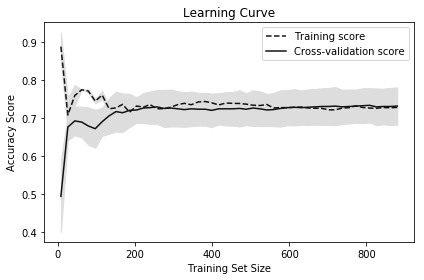

In [14]:
train_sizes, train_scores, test_scores = learning_curve(gnb, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [15]:
prediction_probabilities = gnb.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.6632653061224489
Precision: 0.6846846846846847
Recall: 0.7102803738317757
Log loss=  2.9108689928729308


In [16]:
scores = cross_val_score(gnb, X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.7311171891436986


In [17]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, feature_list, numeric_feature_to_scale, 
                                            prediction_probabilities, X_test, y_test, y_pred)


                                       Kansas                   Bucknell     Stat Supports Winner
Allow PPG                       65.00                              58.00         True  (L)
FT %                            69.50                              70.10         True  (H)
Takeaway Avg                     6.00                               7.00         True  (H)
Seed                              3                                 14          False  (L)
SAG                              9.00                             114.00        False  (L)
WLK                              7.00                              97.00        False  (L)
WOL                             10.00                              84.00        False  (L)
RTH                              7.00                             137.00        False  (L)
COL                              4.00                             102.00        False  (L)
POM                             12.00                             110.00        Fal

                                     Kentucky                   Michigan     Stat Supports Winner
SOS                              9.90                               9.65         True  (H)
PPG                             74.00                              73.00         True  (H)
Poss Avg                        78.51                              70.12         True  (H)
Off Rb Avg                      14.00                               8.00         True  (H)
Def Rb Avg                      26.00                              22.00         True  (H)
FT ATT Avg                      28.00                              18.00         True  (H)
Seed                              8                                  2          False  (L)
SAG                             18.00                              10.00        False  (L)
WLK                             16.00                              13.00        False  (L)
WOL                             33.00                              10.00        Fal

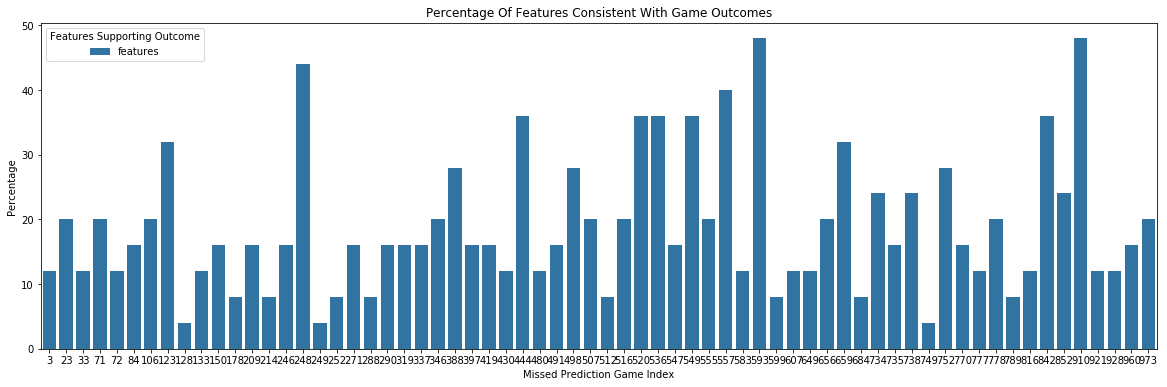

In [18]:
plot_missed_predictions_df = missed_predictions[['game_index','features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

##### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

### Run Model Against 2018 Tournament

In [19]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year]
X_season= X_season.drop(columns=['season_t'])
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

(67, 25)

array([[18, 15],
       [ 9, 25]], dtype=int64)

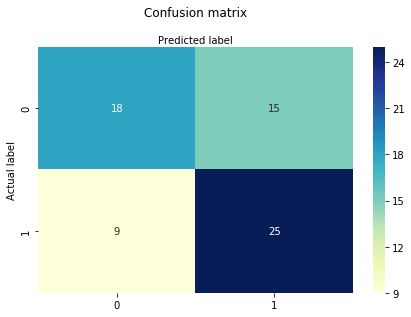

In [20]:
y_pred_season = gnb.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)



In [21]:
prediction_probabilities = gnb.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season))
print("Precision:", metrics.precision_score(y_season,y_pred_season))
print("Recall:",metrics.recall_score(y_season, y_pred_season))
print("Log loss= ",log_loss(y_season, prediction_probabilities))

Accuracy: 0.6417910447761194
Precision: 0.625
Recall: 0.7352941176470589
Log loss=  3.037346334768384


In [22]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, feature_list, numeric_feature_to_scale, 
                                            prediction_probabilities,X_season,y_season,y_pred_season)

                                   Wichita St                   Marshall     Stat Supports Winner
Net Turnover Avg                 7.00                               6.00         True  (L)
PPG                             82.00                              83.00         True  (H)
Poss Avg                        81.03                              83.52         True  (H)
FT %                            73.90                              76.40         True  (H)
Takeaway Avg                     4.00                               7.00         True  (H)
Seed                              4                                 13          False  (L)
SAG                             15.00                             125.00        False  (L)
WLK                             21.00                             102.00        False  (L)
WOL                             14.00                              92.00        False  (L)
RTH                             17.00                             110.00        Fal

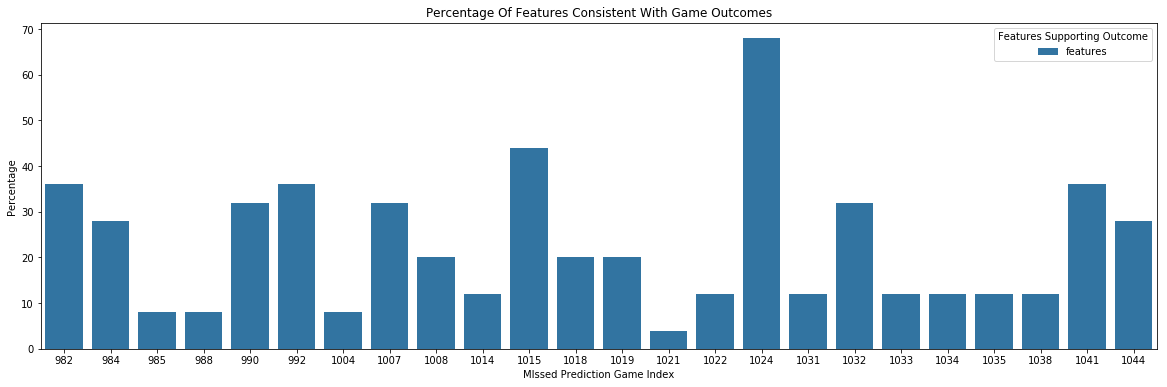

In [23]:
plot_missed_predictions_df = missed_predictions[['game_index','features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('MIssed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)